In [1]:
import sys
sys.path.append('..')
from XAIbenchmark import XAIFramework
import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

d:\EvalxNLP\venv32\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [3]:
import torch
from explainers import InputXGradientExplainer, IntegratedGradientsExplainer, DeepLiftExplainer, LimeExplainer, SHAPExplainer, SHAPIQExplainer, GuidedBackpropExplainer
device = "cuda" if torch.cuda.is_available() else "cpu"
ig= IntegratedGradientsExplainer(model,tokenizer,device)
gb= GuidedBackpropExplainer(model,tokenizer,device)
dl= DeepLiftExplainer(model,tokenizer,device)
ixg= InputXGradientExplainer(model,tokenizer,device,multiply_by_inputs=True)
g= InputXGradientExplainer(model,tokenizer,device,multiply_by_inputs=False)
lime= LimeExplainer(model,tokenizer)
shap= SHAPExplainer(model,tokenizer)
shapiq= SHAPIQExplainer(model,tokenizer)

In [4]:
from evaluators import AUCTPEvaluator, SoftComprehensivenessEvaluator, SoftSufficiencyEvaluator, FADEvaluator, SparsenessEvaluator, ComplexityEvaluator, IOUF1Evaluator,TokenF1Evaluator, AUPRCEvaluator

sc= SoftComprehensivenessEvaluator(model,tokenizer,device)
ss= SoftSufficiencyEvaluator(model,tokenizer,device)
fad= FADEvaluator(model,tokenizer,device)
sp= SparsenessEvaluator(model,tokenizer,device)
cx= ComplexityEvaluator(model,tokenizer,device)
auctp= AUCTPEvaluator(model,tokenizer,device)
iou_f1= IOUF1Evaluator(model,tokenizer,device)
token_f1= TokenF1Evaluator(model,tokenizer,device)
auprc= AUPRCEvaluator(model,tokenizer,device)

In [37]:
xai_framework = XAIFramework(model, tokenizer,explainers=[dl,g], evaluators=[cx,sc],device=device)

In [38]:
sentence= "A masterpiece of how not to make a movie."
xai_framework.classify_text(sentence)

{'negative': 0.07390535622835159,
 'neutral': 0.10088995099067688,
 'positive': 0.8252046704292297}

In [39]:
exps= xai_framework.explain(input_data=sentence,target_label="positive")

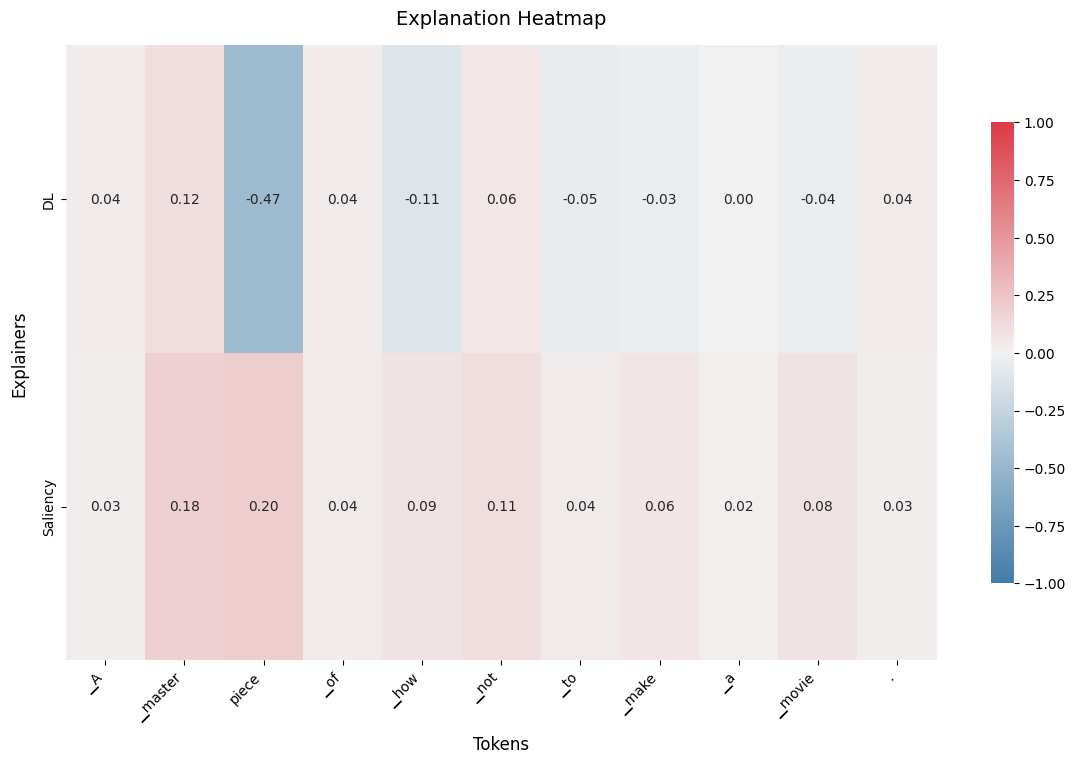

In [40]:
xai_framework.visualize(exps)

In [42]:
from LLMExplanationGenerator import LLMExplanationGenerator
import pandas as pd
from IPython.display import display, HTML

api_key = "9b305c0291728a7f4ca861254b9bedd3e7785d5360100d93603dd1758931be6d"
explainer = LLMExplanationGenerator(api_key=api_key)

# Generate and save explanations (returns both explanations and file paths)
explanations, saved_files = explainer.generate_and_save_explanations(
    exps=exps,
    output_format="both"  # or "json"/"html"
)

# Display in notebook
explainer.display_explanations(explanations)

# Print saved locations
print(f"Saved files: {[str(p) for p in saved_files]}")

file saved in ..\results\llm_explanations\explanations.html


Saved files: ['..\\results\\llm_explanations\\explanations.json', '..\\results\\llm_explanations\\explanations.html']


In [41]:
eval_metrics=xai_framework.evaluate_single_sentence(sentence, target_label="positive")
xai_framework.create_pivot_table(eval_metrics, save_path="../results/testing_1.xlsx")

Results saved to ../results/testing_1.xlsx


Evaluator,Soft Comprehensiveness ↑,Complexity ↓
Explainer,,
DL,0.509450,0.138568
Saliency,0.509413,0.180742


In [43]:
from EvaluationMetricsExplainer import EvaluationMetricsExplainer

api_key = "9b305c0291728a7f4ca861254b9bedd3e7785d5360100d93603dd1758931be6d"
explainer = EvaluationMetricsExplainer(api_key=api_key)

results = explainer.explain_results(eval_metrics)
# json_path, html_path = explainer.save_results(results)
explainer.display_results(results)

In [6]:
from dataset_loaders.dataset_loader import LoadDatasetArgs,load_fields_from_dataset

dataset_args_ = LoadDatasetArgs(
    dataset_name="eraser-benchmark/movie_rationales",
    text_field="review",
    label_field="label",
    rationale_field="evidences",
    dataset_split="test",
)

# Load the dataset fields
results = load_fields_from_dataset(dataset_args_)

Loading dataset...


In [7]:
input_texts= results['text']
labels= results['labels']
rationales= results['rationales']

In [8]:
from dataset_loaders.movie_rationales import MovieRationalesProcessor

mv= MovieRationalesProcessor(tokenizer)
processed_rationales= mv.process_dataset(input_texts, labels, rationales)

In [9]:
#Select a sub-sample if you want
input_texts_sample=results['text'][:2]
labels_sample=results['labels'][:2]
rationale_sample= processed_rationales[:2]

In [10]:
exp_scores= xai_framework.get_feature_importance_for_dataset(input_texts_sample,labels_sample,rationale_sample)

Processing instance 0
Found cached explanation for DL
Processing instance 1
Found cached explanation for DL


In [11]:
from LLMExplanationGenerator import LLMExplanationGenerator
import pandas as pd
from IPython.display import display, HTML

api_key = "9b305c0291728a7f4ca861254b9bedd3e7785d5360100d93603dd1758931be6d"
explainer = LLMExplanationGenerator(api_key=api_key)

# Generate and save explanations (returns both explanations and file paths)
explanations, saved_files = explainer.generate_and_save_explanations(
    exps=exp_scores,
    output_format="both"  # or "json"/"html"
)

# Display in notebook
explainer.display_explanations(explanations)

# Print saved locations
print(f"Saved files: {[str(p) for p in saved_files]}")

file saved in ..\results\llm_explanations\explanations.html


Saved files: ['..\\results\\llm_explanations\\explanations.json', '..\\results\\llm_explanations\\explanations.html']


In [12]:
metrics= xai_framework.compute_evaluation_metrics(exp_scores)


Explainer: DL
Computing value for Complexity ↓
Computing value for Soft Comprehensiveness ↑


In [13]:
xai_framework.create_pivot_table(metrics, save_path="../results/testing.xlsx")

Results saved to ../results/testing.xlsx


Evaluator,Soft Comprehensiveness ↑,Complexity ↓
Explainer,,
DL,0.155089,0.011019


In [28]:
from EvaluationMetricsExplainer import EvaluationMetricsExplainer

api_key = "9b305c0291728a7f4ca861254b9bedd3e7785d5360100d93603dd1758931be6d"
explainer = EvaluationMetricsExplainer(api_key=api_key)

results = explainer.explain_results(metrics)
json_path, html_path = explainer.save_results(results)

{'Complexity ↓': {'definition': 'Measures explanation conciseness by computing the entropy of normalized attribution scores. Lower values indicate simpler explanations focusing on few key features, while higher values suggest distributed feature importance', 'direction': 'lower is better', 'range': '0-1', 'explanations': {'DL': {'value': 0.011018693912774324, 'interpretation': "The DL method's score of 0.011 on the Complexity ↓ metric indicates that its explanations are highly concise, focusing on a very small subset of key features. This suggests good performance, as lower values are preferred, implying that the method is able to identify the most important features without distributing importance across many features. In comparison to the ideal value of 0, the DL method's score is very close, indicating that its explanations are nearly optimal in terms of simplicity and conciseness."}}}, 'Soft Comprehensiveness ↑': {'definition': "Measures how much the model's prediction relies on im

In [32]:
explainer.display_results(results)